In [385]:
import os
import gc
import copy
import time
import random
import string

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

# Utils
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, KFold

# For Transformer Models
from transformers import AutoTokenizer, AutoModel, AdamW

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [388]:
CONFIG = {
    "seed": 2021,
    "epochs": 3,
    "model_name": "roberta-base",
    "train_batch_size": 32,
    "valid_batch_size": 64,
    "max_length": 128,
    "learning_rate": 2e-5,
    "scheduler": 'CosineAnnealingLR',
    "min_lr": 1e-6,
    "T_max": 500,
    "weight_decay": 1e-6,
    "n_fold": 5,
    "n_accumulate": 1,
    "num_classes": 1,
    "margin": 0.5,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
}

CONFIG["tokenizer"] = AutoTokenizer.from_pretrained(CONFIG['model_name'])

In [389]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

# Read the Data

In [390]:
df = pd.read_csv("data/validation_data.csv")
df.head()

,worker,less_toxic,more_toxic
0,313,This article sucks \n\nwoo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...
1,188,"""And yes, people should recognize that but the...",Daphne Guinness \n\nTop of the mornin' my fav...
2,82,"Western Media?\n\nYup, because every crime in...","""Atom you don't believe actual photos of mastu..."
3,347,And you removed it! You numbskull! I don't car...,You seem to have sand in your vagina.\n\nMight...
4,539,smelly vagina \n\nBluerasberry why don't you ...,"hey \n\nway to support nazis, you racist"


## Prepare sentence features

In [7]:
import joblib

puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', '$', '&',
          '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
          '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›', 
          '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', 
          '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯',
          '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔',
          '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', '\n', '\r']

with open('jigsaw-crawl-300d-2M.joblib', 'rb') as f:
    crawl_emb_dict = joblib.load(f)

with open('google-profanity-words/profanity.js', 'r') as handle:
    p_words = handle.readlines()
    
set_puncts = set(puncts)

p_word_set = set([t.replace('\n', '') for t in p_words])

def sentence_fetures(text):
    word_list = text.split()
    word_count = len(word_list)
    n_upper = len([word for word in word_list if any([c.isupper() for c in word])])
    n_unique = len(set(word_list))
    n_ex = word_list.count('!')
    n_que = word_list.count('?')
    n_puncts = len([word for word in word_list if word in set_puncts])
    n_prof = len([word for word in word_list if word in p_word_set])
    n_oov = len([word for word in word_list if word not in crawl_emb_dict])
    
    return word_count, n_upper, n_unique, n_ex, n_que, n_puncts, n_prof, n_oov

sentence_feature_cols = ['word_count', 'n_upper', 'n_unique', 'n_ex', 'n_que', 'n_puncts', 'n_prof', 'n_oov']

In [391]:
from collections import defaultdict

feature_dict = defaultdict(list)

sentence_df = {}

for text in tqdm(df['less_toxic']):
    feature_list = sentence_fetures(text)
    for i_feature, feature_name in enumerate(sentence_feature_cols):
        feature_dict[sentence_feature_cols[i_feature]].append(feature_list[i_feature])
        
sentence_df['less'] = pd.DataFrame.from_dict(feature_dict)

for col in ['n_upper', 'n_unique', 'n_ex', 'n_que', 'n_puncts', 'n_prof', 'n_oov']:
    sentence_df['less'][col + '_ratio'] = sentence_df['less'][col] / sentence_df['less']['word_count']
    
sentence_df['less'].head()

100%|██████████| 30108/30108 [00:01<00:00, 29430.28it/s]


,word_count,n_upper,n_unique,n_ex,n_que,n_puncts,n_prof,n_oov,n_upper_ratio,n_unique_ratio,n_ex_ratio,n_que_ratio,n_puncts_ratio,n_prof_ratio,n_oov_ratio
0,6,1,5,0,0,0,0,0,0.166667,0.833333,0.0,0.0,0.000000,0.000000,0.000000
1,39,4,38,0,0,1,0,4,0.102564,0.974359,0.0,0.0,0.025641,0.000000,0.102564
2,16,4,15,0,0,0,0,3,0.250000,0.937500,0.0,0.0,0.000000,0.000000,0.187500
3,27,4,26,0,0,1,0,6,0.148148,0.962963,0.0,0.0,0.037037,0.000000,0.222222
4,22,2,20,0,0,0,2,1,0.090909,0.909091,0.0,0.0,0.000000,0.090909,0.045455


In [392]:
sentence_df['less'].columns = [col + '_less' for col in sentence_df['less'].columns]

In [393]:
feature_dict = defaultdict(list)

for text in tqdm(df['more_toxic']):
    feature_list = sentence_fetures(text)
    for i_feature, feature_name in enumerate(sentence_feature_cols):
        feature_dict[sentence_feature_cols[i_feature]].append(feature_list[i_feature])
        
sentence_df['more'] = pd.DataFrame.from_dict(feature_dict)

for col in ['n_upper', 'n_unique', 'n_ex', 'n_que', 'n_puncts', 'n_prof', 'n_oov']:
    sentence_df['more'][col + '_ratio'] = sentence_df['more'][col] / sentence_df['more']['word_count']
    
sentence_df['more'].head()

100%|██████████| 30108/30108 [00:00<00:00, 30679.37it/s]


,word_count,n_upper,n_unique,n_ex,n_que,n_puncts,n_prof,n_oov,n_upper_ratio,n_unique_ratio,n_ex_ratio,n_que_ratio,n_puncts_ratio,n_prof_ratio,n_oov_ratio
0,14,11,13,0,0,0,0,2,0.785714,0.928571,0.0,0.0,0.000000,0.000000,0.142857
1,41,12,37,0,0,0,1,4,0.292683,0.902439,0.0,0.0,0.000000,0.024390,0.097561
2,91,11,68,0,0,1,1,8,0.120879,0.747253,0.0,0.0,0.010989,0.010989,0.087912
3,17,2,16,0,0,0,0,0,0.117647,0.941176,0.0,0.0,0.000000,0.000000,0.000000
4,7,0,7,0,0,0,0,1,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.142857


In [394]:
sentence_df['more'].columns = [col + '_more' for col in sentence_df['more'].columns]

In [395]:
valid_df = pd.concat([df, sentence_df['less'], sentence_df['more']], axis=1)

In [396]:
valid_df.head()

,worker,less_toxic,more_toxic,word_count_less,n_upper_less,n_unique_less,n_ex_less,n_que_less,n_puncts_less,n_prof_less,...,n_puncts_more,n_prof_more,n_oov_more,n_upper_ratio_more,n_unique_ratio_more,n_ex_ratio_more,n_que_ratio_more,n_puncts_ratio_more,n_prof_ratio_more,n_oov_ratio_more
0,313,This article sucks \n\nwoo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...,6,1,5,0,0,0,0,...,0,0,2,0.785714,0.928571,0.0,0.0,0.000000,0.000000,0.142857
1,188,"""And yes, people should recognize that but the...",Daphne Guinness \n\nTop of the mornin' my fav...,39,4,38,0,0,1,0,...,0,1,4,0.292683,0.902439,0.0,0.0,0.000000,0.024390,0.097561
2,82,"Western Media?\n\nYup, because every crime in...","""Atom you don't believe actual photos of mastu...",16,4,15,0,0,0,0,...,1,1,8,0.120879,0.747253,0.0,0.0,0.010989,0.010989,0.087912
3,347,And you removed it! You numbskull! I don't car...,You seem to have sand in your vagina.\n\nMight...,27,4,26,0,0,1,0,...,0,0,0,0.117647,0.941176,0.0,0.0,0.000000,0.000000,0.000000
4,539,smelly vagina \n\nBluerasberry why don't you ...,"hey \n\nway to support nazis, you racist",22,2,20,0,0,0,2,...,0,0,1,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.142857


In [397]:
df = pd.read_parquet('data/rudd_sample_all_diffs_w_sampling.parquet')

In [399]:
df.shape

(345270, 6)

In [400]:
from collections import defaultdict

feature_dict = defaultdict(list)

sentence_df = {}

for text in tqdm(df['less_toxic']):
    feature_list = sentence_fetures(text)
    for i_feature, feature_name in enumerate(sentence_feature_cols):
        feature_dict[sentence_feature_cols[i_feature]].append(feature_list[i_feature])
        
sentence_df['less'] = pd.DataFrame.from_dict(feature_dict)

for col in ['n_upper', 'n_unique', 'n_ex', 'n_que', 'n_puncts', 'n_prof', 'n_oov']:
    sentence_df['less'][col + '_ratio'] = sentence_df['less'][col] / sentence_df['less']['word_count']
    
sentence_df['less'].head()

100%|██████████| 345270/345270 [00:05<00:00, 66605.67it/s] 


,word_count,n_upper,n_unique,n_ex,n_que,n_puncts,n_prof,n_oov,n_upper_ratio,n_unique_ratio,n_ex_ratio,n_que_ratio,n_puncts_ratio,n_prof_ratio,n_oov_ratio
0,13,3,12,0,0,0,0,1,0.230769,0.923077,0.0,0.0,0.0,0.0,0.076923
1,9,1,9,0,0,0,0,1,0.111111,1.000000,0.0,0.0,0.0,0.0,0.111111
2,14,1,14,0,0,0,0,1,0.071429,1.000000,0.0,0.0,0.0,0.0,0.071429
3,8,2,8,0,0,0,0,0,0.250000,1.000000,0.0,0.0,0.0,0.0,0.000000
4,8,2,8,0,0,0,0,2,0.250000,1.000000,0.0,0.0,0.0,0.0,0.250000


In [401]:
sentence_df['less'].columns

Index(['word_count', 'n_upper', 'n_unique', 'n_ex', 'n_que', 'n_puncts',
       'n_prof', 'n_oov', 'n_upper_ratio', 'n_unique_ratio', 'n_ex_ratio',
       'n_que_ratio', 'n_puncts_ratio', 'n_prof_ratio', 'n_oov_ratio'],
      dtype='object')

In [402]:
sentence_df['less'].columns = [col + '_less' for col in sentence_df['less'].columns]

In [403]:
feature_dict = defaultdict(list)

for text in tqdm(df['more_toxic']):
    feature_list = sentence_fetures(text)
    for i_feature, feature_name in enumerate(sentence_feature_cols):
        feature_dict[sentence_feature_cols[i_feature]].append(feature_list[i_feature])
        
sentence_df['more'] = pd.DataFrame.from_dict(feature_dict)

for col in ['n_upper', 'n_unique', 'n_ex', 'n_que', 'n_puncts', 'n_prof', 'n_oov']:
    sentence_df['more'][col + '_ratio'] = sentence_df['more'][col] / sentence_df['more']['word_count']
    
sentence_df['more'].head()

100%|██████████| 345270/345270 [00:05<00:00, 65184.43it/s]


,word_count,n_upper,n_unique,n_ex,n_que,n_puncts,n_prof,n_oov,n_upper_ratio,n_unique_ratio,n_ex_ratio,n_que_ratio,n_puncts_ratio,n_prof_ratio,n_oov_ratio
0,12,2,12,0,0,0,0,1,0.166667,1.000000,0.0,0.0,0.0,0.0,0.083333
1,8,2,8,0,0,0,0,0,0.250000,1.000000,0.0,0.0,0.0,0.0,0.000000
2,4,2,4,0,0,0,0,1,0.500000,1.000000,0.0,0.0,0.0,0.0,0.250000
3,24,2,22,0,0,0,0,3,0.083333,0.916667,0.0,0.0,0.0,0.0,0.125000
4,11,1,9,0,0,0,0,0,0.090909,0.818182,0.0,0.0,0.0,0.0,0.000000


In [404]:
sentence_df['more'].columns = [col + '_more' for col in sentence_df['more'].columns]

In [405]:
df = pd.concat([df, sentence_df['less'], sentence_df['more']], axis=1)

# Create Folds

In [406]:
skf = StratifiedKFold(n_splits=CONFIG['n_fold'], shuffle=True, random_state=CONFIG['seed'])

for fold, ( _, val_) in enumerate(skf.split(X=df, y=df.bins)):
    df.loc[val_ , "kfold"] = int(fold)
    
df["kfold"] = df["kfold"].astype(int)
df.head()

,less_toxic,more_toxic,bin1,bin2,bins,score,word_count_less,n_upper_less,n_unique_less,n_ex_less,...,n_prof_more,n_oov_more,n_upper_ratio_more,n_unique_ratio_more,n_ex_ratio_more,n_que_ratio_more,n_puncts_ratio_more,n_prof_ratio_more,n_oov_ratio_more,kfold
0,You go man! I wish I could spend all day with ...,Distance made it difficult long with other con...,0,0,0-0,0.122,13,3,12,0,...,0,1,0.166667,1.000000,0.0,0.0,0.0,0.0,0.083333,1
1,Can you give us some examples of the food?,This has JUST the right amount of points,0,0,0-0,0.042,9,1,9,0,...,0,0,0.250000,1.000000,0.0,0.0,0.0,0.0,0.000000,0
2,"Love it bro, i actually think that this is bet...",Same happened to r/VaccinesCause,0,0,0-0,0.030,14,1,14,0,...,0,1,0.500000,1.000000,0.0,0.0,0.0,0.0,0.250000,2
3,So so awesome. Really want to see more.,"Every time I load a page, switch to game and t...",0,0,0-0,0.271,8,2,8,0,...,0,3,0.083333,0.916667,0.0,0.0,0.0,0.0,0.125000,0
4,Thanks and good luck! You can do it!!,He was too good at it and realized it too late.,0,0,0-0,0.135,8,2,8,0,...,0,0,0.090909,0.818182,0.0,0.0,0.0,0.0,0.000000,3


# Dataset Class

In [407]:
SENTENCE_FEATURE_USED = [
    'word_count', 'n_upper', 'n_unique', 'n_ex', 'n_que', 'n_puncts',
    'n_prof', 'n_oov', 'n_upper_ratio', 'n_unique_ratio', 'n_ex_ratio',
    'n_que_ratio', 'n_puncts_ratio', 'n_prof_ratio', 'n_oov_ratio'
]

In [408]:
class JigsawDataset(Dataset):
    def __init__(self, df, data, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.more_toxic = df['more_toxic'].values
        self.less_toxic = df['less_toxic'].values
        self.less_data = data[:, :len(SENTENCE_FEATURE_USED)]
        self.more_data = data[:, len(SENTENCE_FEATURE_USED):]
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        more_toxic = self.more_toxic[index]
        less_toxic = self.less_toxic[index]
        
        less_data = self.less_data[index]
        more_data = self.more_data[index]
        
        inputs_more_toxic = self.tokenizer.encode_plus(
                                more_toxic,
                                truncation=True,
                                add_special_tokens=True,
                                max_length=self.max_len,
                                padding='max_length'
                            )
        inputs_less_toxic = self.tokenizer.encode_plus(
                                less_toxic,
                                truncation=True,
                                add_special_tokens=True,
                                max_length=self.max_len,
                                padding='max_length'
                            )
        target = 1
        
        more_toxic_ids = inputs_more_toxic['input_ids']
        more_toxic_mask = inputs_more_toxic['attention_mask']
        
        less_toxic_ids = inputs_less_toxic['input_ids']
        less_toxic_mask = inputs_less_toxic['attention_mask']
        
        
        return {
            'more_toxic_ids': torch.tensor(more_toxic_ids, dtype=torch.long),
            'more_toxic_mask': torch.tensor(more_toxic_mask, dtype=torch.long),
            'more_toxic_data': torch.tensor(more_data, dtype=torch.float),
            'less_toxic_ids': torch.tensor(less_toxic_ids, dtype=torch.long),
            'less_toxic_mask': torch.tensor(less_toxic_mask, dtype=torch.long),
            'less_toxic_data': torch.tensor(less_data, dtype=torch.float),
            'target': torch.tensor(target, dtype=torch.long)
        }

# Create Model

In [409]:
from transformers import BertModel, RobertaModel
import torch.nn.functional as F

OUT_DROPOUT = 0.3
BERT_N_LAST_LAYER = 4
BERT_HIDDEN_SIZE = 768

BERT_MODEL_PATH = 'roberta-base'
BERT_DO_LOWER = 'uncased' in BERT_MODEL_PATH

MAX_LEN = 220

class JigsawModel(nn.Module):
    def __init__(self, num_aux_targets, num_sentence_features):
        super(JigsawModel, self).__init__()
        self.bert_model = RobertaModel.from_pretrained(BERT_MODEL_PATH)
        self.dropout = nn.Dropout(OUT_DROPOUT)
        
        self.linear_sentence1 = nn.Linear(num_sentence_features, num_sentence_features)
        
        n_hidden = BERT_HIDDEN_SIZE + num_sentence_features
        self.linear1 = nn.Linear(n_hidden, n_hidden)
        
        self.linear_out = nn.Linear(n_hidden, 1)
        self.linear_aux_out = nn.Linear(n_hidden, num_aux_targets)
        
    def forward(self, ids, attention, sentence_features):
        
        bert_output = self.bert_model(ids, attention)[1]
        
        bert_output = self.dropout(bert_output)
        
        h_sentence = self.linear_sentence1(sentence_features)
        
        h_cat = torch.cat((bert_output, h_sentence), 1)
        
        h_conc_linear1  = F.relu(self.linear1(h_cat))
        
        hidden = h_cat + h_conc_linear1
        
        result = self.linear_out(hidden)
        aux_result = self.linear_aux_out(hidden)
        out = torch.cat([result, aux_result], 1)
        
        return out

In [410]:
def criterion(outputs1, outputs2, targets):
    return nn.MarginRankingLoss(margin=CONFIG['margin'])(outputs1, outputs2, targets)

# Training Function

In [411]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        more_toxic_ids = data['more_toxic_ids'].to(device, dtype = torch.long)
        more_toxic_mask = data['more_toxic_mask'].to(device, dtype = torch.long)
        more_toxic_data = data['more_toxic_data'].to(device)
        less_toxic_ids = data['less_toxic_ids'].to(device, dtype = torch.long)
        less_toxic_mask = data['less_toxic_mask'].to(device, dtype = torch.long)
        less_toxic_data = data['less_toxic_data'].to(device)
        targets = data['target'].to(device, dtype=torch.long)
        
        batch_size = more_toxic_ids.size(0)

        more_toxic_outputs = model(more_toxic_ids, more_toxic_mask, more_toxic_data)
        less_toxic_outputs = model(less_toxic_ids, less_toxic_mask, less_toxic_data)
        
        loss = criterion(
            more_toxic_outputs, less_toxic_outputs, 
            torch.ones_like(less_toxic_outputs).to(CONFIG['device'])
        )
        loss = loss / CONFIG['n_accumulate']
        loss.backward()
    
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss

# Validation Function

In [412]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    all_more = []
    all_less = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:        
        more_toxic_ids = data['more_toxic_ids'].to(device, dtype = torch.long)
        more_toxic_mask = data['more_toxic_mask'].to(device, dtype = torch.long)
        more_toxic_data = data['more_toxic_data'].to(device)
        less_toxic_ids = data['less_toxic_ids'].to(device, dtype = torch.long)
        less_toxic_mask = data['less_toxic_mask'].to(device, dtype = torch.long)
        less_toxic_data = data['less_toxic_data'].to(device)
        targets = data['target'].to(device, dtype=torch.long)
        
        batch_size = more_toxic_ids.size(0)

        more_toxic_outputs = model(more_toxic_ids, more_toxic_mask, more_toxic_data)
        less_toxic_outputs = model(less_toxic_ids, less_toxic_mask, less_toxic_data)
        
        all_more += [more_toxic_outputs.detach().cpu().numpy()]
        all_less += [less_toxic_outputs.detach().cpu().numpy()]
        
        try:
            epoch_loss = (np.hstack(all_more) > np.hstack(all_less)).mean()
            prev_epoch_loss = epoch_loss
        except:
            epoch_loss = prev_epoch_loss
        
        bar.set_postfix(
            Epoch=epoch, Valid_Loss=epoch_loss,
            LR=optimizer.param_groups[0]['lr']
        )
    
    gc.collect()
    
    return epoch_loss

# Run Training

In [413]:
def run_training(model, optimizer, scheduler, device, num_epochs, fold):
    
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_loss = 0
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CONFIG['device'], epoch=epoch)
        
        val_epoch_loss = valid_one_epoch(model, valid_loader, device=CONFIG['device'], 
                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)

        # deep copy the model
        if val_epoch_loss > best_epoch_loss:
            print(f"Validation Loss Improved ({best_epoch_loss} ---> {val_epoch_loss})")
            best_epoch_loss = val_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"Loss-Fold-{fold}_roberta_base_exp.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved")
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss: {:.4f}".format(best_epoch_loss))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

In [414]:
from sklearn.preprocessing import StandardScaler
import pickle
import joblib

def prepare_loaders(fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = valid_df.reset_index(drop=True)
    
    sc = joblib.load(
        '/home/anton/Documents/kaggle/jigsaw/Jigsaw-Unintended-Bias/models/fine-tune-roberta/scaler-seed0-fold0.joblib'
    )
    less_features = [s+'_less' for s in SENTENCE_FEATURE_USED]
    more_features = [s+'_more' for s in SENTENCE_FEATURE_USED]
    
    data_train = np.hstack([
        sc.transform(df_train[less_features].values),
        sc.transform(df_train[more_features].values)
    ])
    
    data_valid = np.hstack([
        sc.transform(df_valid[less_features].values),
        sc.transform(df_valid[more_features].values)
    ])
    
    train_dataset = JigsawDataset(
        df_train, data_train, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length']
    )
    valid_dataset = JigsawDataset(
        df_valid, data_valid, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length']
    )

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], 
                              num_workers=16, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], 
                              num_workers=16, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

In [415]:
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'], 
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None
        
    return scheduler

In [416]:
train_loader, valid_loader = prepare_loaders(fold)

model = JigsawModel(6, 15)
model.load_state_dict(
    torch.load(
        '/home/anton/Documents/kaggle/jigsaw/Jigsaw-Unintended-Bias/models/fine-tune-roberta/seed0-fold0-epoch0.torchModelState'
    )
)
model.to(CONFIG['device'])

optimizer = AdamW(
    model.parameters(), lr=CONFIG['learning_rate'], 
    weight_decay=CONFIG['weight_decay']
)
scheduler = fetch_scheduler(optimizer)

model, history = run_training(
    model, optimizer, scheduler,
    device=CONFIG['device'],
    num_epochs=CONFIG['epochs'],
    fold=fold
)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[INFO] Using GPU: NVIDIA RTX A5000



100%|██████████| 471/471 [01:12<00:00,  6.48it/s, Epoch=1, LR=4.04e-6, Valid_Loss=0.693]


Validation Loss Improved (0 ---> 0.6925626899696049)
Model Saved



100%|██████████| 471/471 [01:12<00:00,  6.45it/s, Epoch=2, LR=9.78e-6, Valid_Loss=0.693]


Validation Loss Improved (0.6925626899696049 ---> 0.6932038373860182)
Model Saved



100%|██████████| 471/471 [01:12<00:00,  6.46it/s, Epoch=3, LR=1.79e-5, Valid_Loss=0.689]



Training complete in 2h 5m 39s
Best Loss: 0.6932


# Run on validation pairs 

In [417]:
@torch.no_grad()
def _valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    all_more = []
    all_less = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:        
        more_toxic_ids = data['more_toxic_ids'].to(device, dtype = torch.long)
        more_toxic_mask = data['more_toxic_mask'].to(device, dtype = torch.long)
        more_toxic_data = data['more_toxic_data'].to(device)
        less_toxic_ids = data['less_toxic_ids'].to(device, dtype = torch.long)
        less_toxic_mask = data['less_toxic_mask'].to(device, dtype = torch.long)
        less_toxic_data = data['less_toxic_data'].to(device)
        targets = data['target'].to(device, dtype=torch.long)
        
        batch_size = more_toxic_ids.size(0)

        more_toxic_outputs = model(more_toxic_ids, more_toxic_mask, more_toxic_data)
        less_toxic_outputs = model(less_toxic_ids, less_toxic_mask, less_toxic_data)
        
        all_more += [more_toxic_outputs.detach().cpu().numpy()]
        all_less += [less_toxic_outputs.detach().cpu().numpy()]
        
        try:
            epoch_loss = (np.hstack(all_more) > np.hstack(all_less)).mean()
            prev_epoch_loss = epoch_loss
        except:
            epoch_loss = prev_epoch_loss
        
        bar.set_postfix(
            Epoch=epoch, Valid_Loss=epoch_loss
        )
    
    gc.collect()
    
    return all_more, all_less

In [355]:
# model = JigsawModel(6, 15)
# model.load_state_dict(
#     torch.load(
#         f"Loss-Fold-4_roberta_large.bin"
#     )
# )
# model.to(CONFIG['device']);

In [418]:
_, valid_loader = prepare_loaders(fold)

In [419]:
out_more, out_less = _valid_one_epoch(model, valid_loader, CONFIG['device'], 0)

100%|██████████| 471/471 [01:11<00:00,  6.63it/s, Epoch=0, Valid_Loss=0.693]


In [420]:
out_more = np.concatenate(out_more)
out_less = np.concatenate(out_less)

In [424]:
valid_df['preds_less'] = out_less[:, 0]
valid_df['preds_more'] = out_more[:, 0]

In [425]:
(valid_df['preds_less'] < valid_df['preds_more']).mean()

0.6938355254417431

## Unique pairs validation

In [ ]:
less_df = valid_df[['less_toxic', 'preds_less']]
less_df.columns = ['txt', 'pred']

more_df = valid_df[['more_toxic', 'preds_more']]
more_df.columns = ['txt', 'pred']

pred_df = pd.concat([less_df, more_df], axis=0).drop_duplicates()
pred_df = pred_df.reset_index(drop=True)

In [426]:
pairs = valid_df[['less_toxic', 'more_toxic']].copy()

pairs['t1'] = pairs.apply(
    lambda x: np.sort([x['less_toxic'], x['more_toxic']])[0], axis=1
)
pairs['t2'] = pairs.apply(
    lambda x: np.sort([x['less_toxic'], x['more_toxic']])[1], axis=1
)

pairs['true'] = 0
pairs.loc[pairs['t2'] == pairs['more_toxic'], 'true'] = 1

base = pairs.groupby(['t1','t2'])['true'].mean().reset_index(name='target')
base['target'] = base['target'].apply(lambda x: -1 if x>=0.5 else 1)

In [435]:
merged = pd.merge(
    base, 
    pred_df.rename(columns={'txt': 't1', 'pred': 'pred_more'}).drop_duplicates(), 
    on='t1', how='left'
)

merged = pd.merge(
    merged, 
    pred_df.rename(columns={'txt': 't2', 'pred': 'pred_less'}).drop_duplicates(), 
    on='t2', how='left'
)

merged['score'] = np.where(merged['pred_less'] < merged['pred_more'], 1, -1)

In [438]:
(merged['score'] == merged['target']).mean()

0.7400039393342525

In [439]:
merged.shape

(10154, 6)

### Error analysis 

<AxesSubplot:>

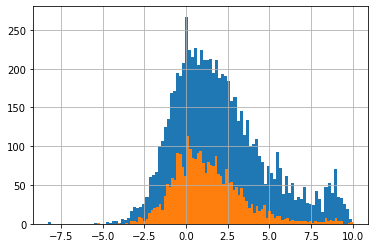

In [440]:
merged[
    (merged['score'] == merged['target'])
    & (merged['pred_less'] < 10)
     ]['pred_less'].hist(bins=100)
merged[merged['score'] != merged['target']]['pred_less'].hist(bins=100)

<AxesSubplot:>

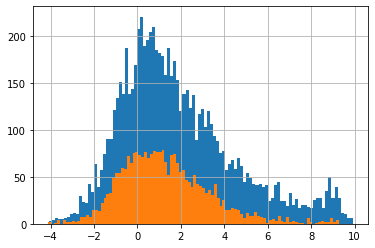

In [441]:
merged[
    (merged['score'] == merged['target'])
    & (merged['pred_more'] < 10)
     ]['pred_more'].hist(bins=100)

merged[
    (merged['score'] != merged['target'])
    & (merged['pred_more'] < 10)
]['pred_more'].hist(bins=100)

In [442]:
merged['diff'] = merged['pred_more'] - merged['pred_less']

<AxesSubplot:>

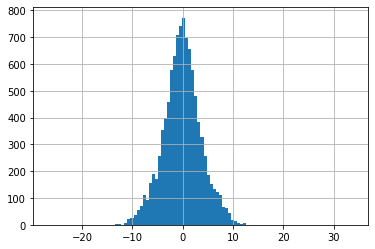

In [443]:
merged['diff'].hist(bins=100)

<AxesSubplot:>

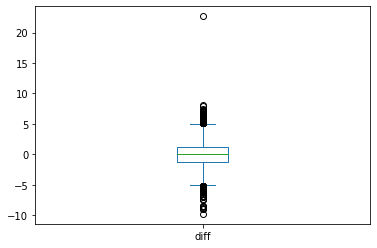

In [444]:
merged[
    (merged['score'] != merged['target'])
]['diff'].plot(kind='box')

<AxesSubplot:>

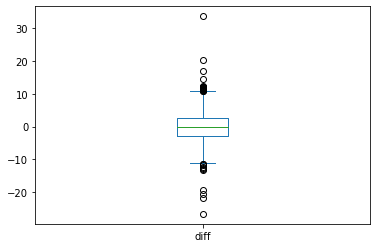

In [445]:
merged[
    (merged['score'] == merged['target'])
]['diff'].plot(kind='box')

<AxesSubplot:>

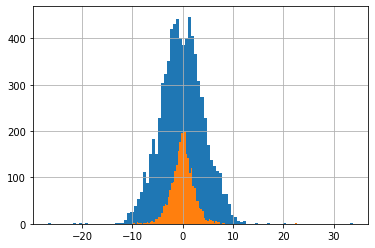

In [446]:
merged[
    (merged['score'] == merged['target'])
]['diff'].hist(bins=100)

merged[
    (merged['score'] != merged['target'])
]['diff'].hist(bins=100)